<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Electronics Purchase Prediction

Today you are a machine learning engineer in the Department of Marketing and Inventory at Walmart Labs. You have access to the Walmart server data, specifically the Electronics section. However, there is no customer facing information, but you do have access to timestamped data regarding product viewing/carting/purchasing. We will use this data to build a model of whether or not some product will be purchased.

Data is adapted from [e-commerce behavior data on Kaggle](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store). 

This file contains behavior data from a large multi-category store. Each row in the file represents an event. All events are related to products and users. Each event has a many-to-many relationship between users and products. 

## Learning Objectives

At the end of this session, you will be able to

- Leverage `pandas_profiling` for fast data understanding
- Practice data preprocessing
- Build logistic regression / SVM / Gradient Boosting
- Evaluate models with proper metrics
- Interpret black box models with SHAP
- Generate optimal pipeline for classification task using AutoML

## Task 1: Load data

Let's start by looking at the descriptions before loading in the csv files.

1. Use the `IPython.display` module to view the `some_column_descriptions.png` file. Look through the column names and descriptions to get an idea of what the data is.

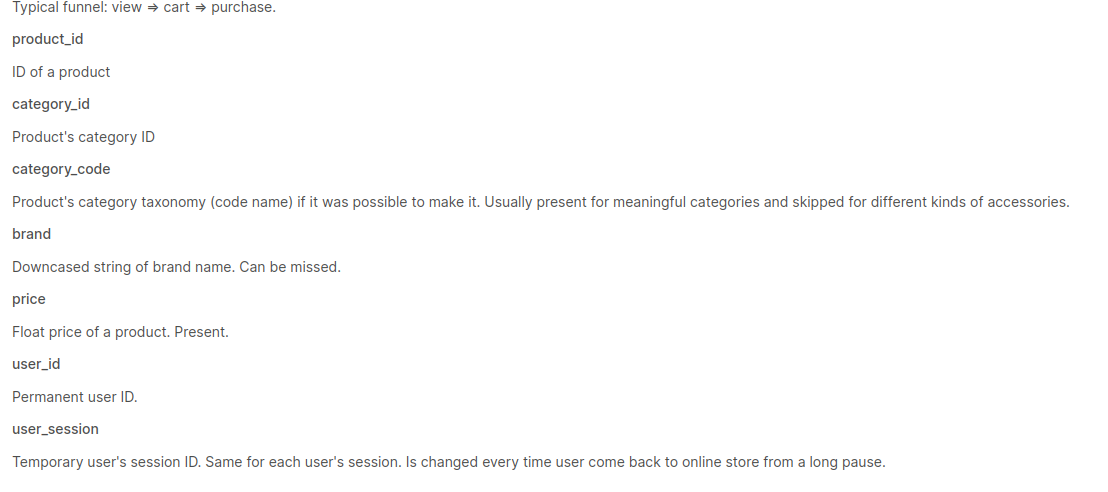

In [1]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/some_column_descriptions.png'
display(Image(filename=filename))

The dataset has User-journey data, i.e., it tracks information on user/product pairs over time to see if the combination results in a purchase.

2. Look at the `user_journey_descriptions.png` file. Review the data sample to get a sense of what information we are tracking for each user/product pair.

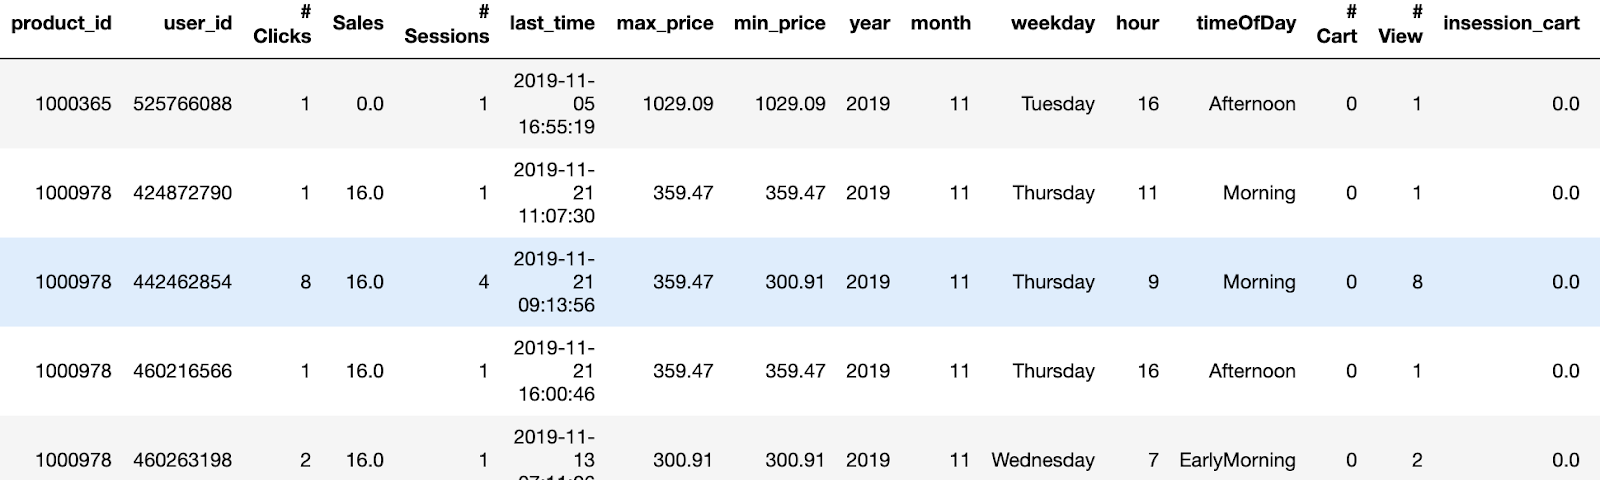

In [2]:
# change path to wherever you uploaded/downloaded the file
filename='../img/user_journey_descriptions.png'
display(Image(filename=filename))

The dataset we are working with is essentially what we have screenshotted above, but has been anonymized by removing product IDs and user IDs.

3. Use the pandas `read_csv()` and `head()` functions to read in the training data (`../dat/train.csv.gz`) and look at the first few rows.

    Note the `Purchase` column has values either 0 (not purchased) or 1 (purchased).

In [3]:
import pandas as pd
train_df = pd.read_csv("../dat/train.csv.gz", compression='gzip')     #--- YOUR CODE HERE

In [4]:
# YOUR CODE HERE
train_df.head(10)

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,Sat,Morning,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,Fr,Dawn,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,Thu,Afternoon,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,Mon,Noon,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,Tue,Noon,0,0
5,1,1,0.0,244.54,244.54,0,1,0,1,2019,11,Sat,Noon,0,0
6,1,1,0.0,234.24,234.24,0,1,0,1,2019,11,Sat,Morning,0,0
7,1,1,0.0,463.31,463.31,0,1,0,1,2019,11,Wed,Evening,0,0
8,1,1,0.0,253.25,253.25,0,1,0,1,2019,11,Thu,Afternoon,0,0
9,1,1,0.0,450.18,450.18,0,1,0,1,2019,11,Mon,Morning,0,0


4. What is the dimension of the training data?

In [5]:
# YOUR CODE HERE
train_df.shape

(645816, 15)

5. Similarly, read in the test data `../dat/test.csv.gz` and check its dimension.

In [6]:
test_df = pd.read_csv("../dat/test.csv.gz", compression='gzip') # YOUR CODE HERE
test_df.shape

(430544, 15)

## Task 2: Understand data

Our goal here is to predict whether a customer/product pair will result in a purchase. 
To do this, we will want to identify the most important features for classification. 

Before digging into each column, let's leverage `pandas_profiling`, that goes beyond `pd.DataFrame.describe()`, to get a big picture of our data set. 

1. From `pandas_profiling` import `ProfileReport`. 
    
    For faster iteration, create a profile report object `profile` with 10,000 samples from `train_df`. 
    
    Set its `title` as "Pandas Profiling Electronics Purchase Report". 
    
    For sampling, use `pd.DataFrame.sample(10000, randome_state=3)`. 

In [7]:
# YOUR CODE HERE
from pandas_profiling import ProfileReport
sample_df = train_df.sample(10000, random_state=3)
profile = ProfileReport(sample_df, title="Pandas Profiling Electronics Purchase Report") # YOUR CODE HERE

   Show the report inside the notebook, go over the report and check each tab; especially the "Alerts". 

#--- INSPECT:  findings
- year, month, weekend columns are constant - drop (3)
- remove duplicate rows?  Consider what to do here ... decision:  do not remove;  they may represent the distribution
- maxPrice and minPrice are highly correlated;  remove 1 col (3+1)
- numOfEventsInJourney, NumSessions, NumCart, NumView, InSessionCart, interactionTime, InSessionView are all highly correlated;  remove all cols but 1 (3+1+6)
- interactionTime is mostly zeroes;  consider what to do here ... 
- interactionTime has outlier(s):  182059 maximum Consider what to do here ...


#--- RESEARCH/REVIEW:
- managing outliers


In [8]:
#%%time
#profile.to_notebook_iframe()    #--- exported to html with to_file() given notebook rendering problems within GitHub


In [9]:
%%time
profile.to_file("profileReport_electronicPurchasePrediction.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 21.1 s, sys: 8.74 s, total: 29.8 s
Wall time: 13 s


2. Pandas profiling Profile reports that there are 5 numeric variables and 11 categorical variables. Let's print out the datatype of each feature (column) and understand how the profiler infers data type. 

In [10]:
#YOUR CODE HERE
train_df.dtypes

NumOfEventsInJourney      int64
NumSessions               int64
interactionTime         float64
maxPrice                float64
minPrice                float64
NumCart                   int64
NumView                   int64
InsessionCart             int64
InsessionView             int64
year                      int64
month                     int64
weekday                  object
timeOfDay                object
Weekend                   int64
Purchase                  int64
dtype: object

3. From the report, we see that `year`, `month`, and `Weekend` were "Rejected" as there is only one distinct value for each column. 
These features are not informative, so we remove the three features from the training set. To do this, pass the `columns` argument to the `.drop()` method. 
Make sure to use `inplace=True` to modify the DataFrame. 
Print the shape of the DataFrames to verify the columns were dropped.

In [11]:
assert train_df.shape[1] == 15

train_df.drop(columns=['year','month','Weekend'], inplace=True)    # YOUR CODE HERE
assert train_df.shape[1] == 12

4. Repeat the steps for `test_df`:

In [12]:
test_df.drop(columns=['year','month','Weekend'], inplace=True)    # YOUR CODE HERE

assert test_df.shape[1] == train_df.shape[1]

5. As you can see from the profile report, `weekday` and `timeOfDay` each has 7 distinct values. 
Convert these non-numeric features to numeric. 

    These feature values are ordered temporally, so it makes sense to convert them to numeric type. 
    Follow the example given for the `weekday` column to update the `timeOfDay` column.
    Use the `.head()` method to inspect the dataset after the transformations.

In [13]:
#--- weekday:  convert non-numeric feature to numeric; 1-based
weekday_str2num = {
    s: i+1 for i, s in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fr', 'Sat', 'Sun'])
}
train_df['weekday'] = train_df['weekday'].replace(weekday_str2num)
train_df['weekday'].unique()

array([6, 5, 4, 1, 2, 3, 7])

In [14]:
#--- timeOfDay:  convert non-numeric feature to numeric; 1-based
timeOfDay_str2num = {
    str: idx+1 for idx, str in enumerate(['Dawn', 'EarlyMorning', 'Morning', 'Noon', \
                                          'Afternoon', 'Evening', 'Night'])
}
train_df['timeOfDay'] = train_df['timeOfDay'].replace(timeOfDay_str2num)    # YOUR CODE HERE
train_df['timeOfDay'].unique()

array([3, 1, 5, 4, 6, 2, 7])

6. Do the same for `test_df`, that is, to convert `weekday` and `timeOfDay` into numeric type. 

In [15]:
#--- test data:  convert non-numeric feature to numeric; 1-based 
test_df['weekday'] = test_df['weekday'].replace(weekday_str2num)     # YOUR CODE HERE
test_df['timeOfDay'] = test_df['timeOfDay'].replace(timeOfDay_str2num)     # YOUR CODE HERE

7. Use the `Purchase` column in training set to determine the proportion of user journeys that result in purchases.  Compare it to what the profile reports. Is the dataset balanced?

In [16]:
#--- INSPECT:  within the training set, proportion of user journeys that result in purchases
#--- ASSUME:  purchases == TRUE == 1

print("number of purchases vs non-purchases in train set:")
print(train_df.Purchase.value_counts(), "\n")

pctPurch = train_df.Purchase.value_counts(1)[1] * 100

#print("percent of rows resulting in purchase: {:.3f}%".format(pctPurch)) # YOUR CODE HERE
print(f"percent of rows resulting in purchase: {pctPurch:.3f}%") # YOUR CODE HERE

number of purchases vs non-purchases in train set:
0    636839
1      8977
Name: Purchase, dtype: int64 

percent of rows resulting in purchase: 1.390%


#--- INSPECT
- Training data (646k): dataframe inspection reveals proportion of purchases at 1.39%
- Sample data (10k):  profile report reveals proportion of purchases at 155/10000 = 1.55%

Q:  Compare the proportion of the training and sample data sets
A:  1.39% compared to 1.55%, respectively.  The values are close.  I infer that the data/value distribution is similar enough between the training and sample data sets


Q:  Is the dataset balanced?
A:  No.  The dataset is not balanced.  With less than 2% of the dataset representing our target outcome, ie user journeys that result in purchases,  there are far more data points.


CONSIDER; ASK ASAD/MAREK:  what if you changed the question to adapt to the data?  That is ... predicting non-purchases, if you have so many indicators for non-purchase?  



## Task 3: Preprocess Data

Correlated features in general don't improve models (although it depends on the specifics of the problem like the number of variables and the degree of correlation), but they affect specific models in different ways and to varying extents:

- For linear models (e.g., linear regression or logistic regression), [multicolinearity](https://en.wikipedia.org/wiki/Multicollinearity) can yield [solutions that are wildly varying and possibly numerically unstable](https://en.wikipedia.org/wiki/Multicollinearity#Consequences).
- Random forest can be good at detecting interactions between different features, but highly correlated features can mask these interactions.
More generally, this can be viewed as a special case of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor). A simpler model is preferable, and, in some sense, a model with fewer features is simpler. The concept of [minimum description length](https://en.wikipedia.org/wiki/Minimum_description_length) makes this more precise ([ref](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)).

1. How many features does our dataset currently have?

#--- INSPECT:
A:  Looking at the remaining cols in the dataset,  I see: 12
- 1 target/outcome column:  purchase
- 11 features


In [17]:
# YOUR CODE HERE
train_df.dtypes

len(train_df.columns)

12

2. Drop the features with high correlation.

    In the "Correlations" tab in the profile report, you can find heatmap using five different correlation metrics; toggle correlation desciptions if any one of them looks foreign to you.  

    We'll remove high correlated features by looking at each pair of features, and if they are highly correlated (at least 0.8), we won't include the second feature in the pair. Store the remaining set of features (the ones you didn't drop) in dataframes `train_df_reduced`. You are given most the code, make sure that you understand what each line does.
    
    First, calculate the correlation with just 10,000 samples.

In [18]:
#--- create a copy of the training dataframe, with a random sampling of 10000 rows (int(1e4))
train_small_df = train_df.copy().sample(n=int(1e4), random_state=12)

#--- generate a correlation matrix across all feature columns, for the sample dataframe
cor = train_small_df.corr()    # YOUR CODE HERE

In [19]:
print(cor)

                      NumOfEventsInJourney  NumSessions  interactionTime  \
NumOfEventsInJourney              1.000000     0.820386         0.502779   
NumSessions                       0.820386     1.000000         0.628841   
interactionTime                   0.502779     0.628841         1.000000   
maxPrice                          0.019786     0.020670         0.013432   
minPrice                          0.018034     0.018456         0.010612   
NumCart                           0.169965     0.145634         0.054007   
NumView                           0.562265     0.462171         0.316047   
InsessionCart                     0.142453     0.108800         0.039385   
InsessionView                     0.099629     0.028005         0.016925   
weekday                           0.023316     0.014853         0.000565   
timeOfDay                        -0.022551    -0.031422        -0.010380   
Purchase                          0.107172     0.074800         0.025312   

           

In [20]:
import numpy as np

#--- cycle through the correlation dataframe/matrix and keep columns that have a correlation >= 0.8
keep_columns = np.full(cor.shape[0], True)       #--- create an array of same shape as cor, filled with Trues
for i in range(cor.shape[0] - 1):
    for j in range(i + 1, cor.shape[0] - 1):
        if (np.abs(cor.iloc[i, j]) >= 0.8):
            keep_columns[j] = False
selected_columns = train_df.columns[keep_columns]
train_df_reduced = train_df[selected_columns]

In [21]:
print(selected_columns) 

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')


3. How many columns are left in the DataFrame?

In [22]:
# YOUR CODE HERE
#--- INSPECT:  9 columns remain in the DataFrame
len(train_df_reduced.columns)

9

In [23]:
train_df_reduced.columns

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')

4. Remove the same features from the test set and save in a new dataframe `test_df_reduced`.

In [24]:
test_df_reduced = test_df[selected_columns]     # YOUR CODE HERE
assert test_df_reduced.shape[1] == 9

In [25]:
test_df_reduced.head(10)

,NumOfEventsInJourney,interactionTime,maxPrice,NumCart,NumView,InsessionView,weekday,timeOfDay,Purchase
0,1,0.0,126.86,0,1,1,3,2,0
1,2,182.0,118.38,0,2,1,5,2,0
2,1,0.0,63.77,0,1,1,5,3,0
3,1,0.0,32.18,0,1,3,5,2,0
4,1,0.0,1093.72,0,1,2,6,2,0
5,1,0.0,51.46,0,1,1,5,2,0
6,1,0.0,324.08,0,1,2,3,5,0
7,1,0.0,257.14,0,1,1,3,2,0
8,1,0.0,0.00,0,1,1,5,5,0
9,1,0.0,169.61,0,1,1,5,5,0


5. Visualize the selected features and discuss your observations with your team.

    Again, for faster rendering, use the subset `train_small_df_reduced`. If time permits, experiment with some other visualizations of the data.

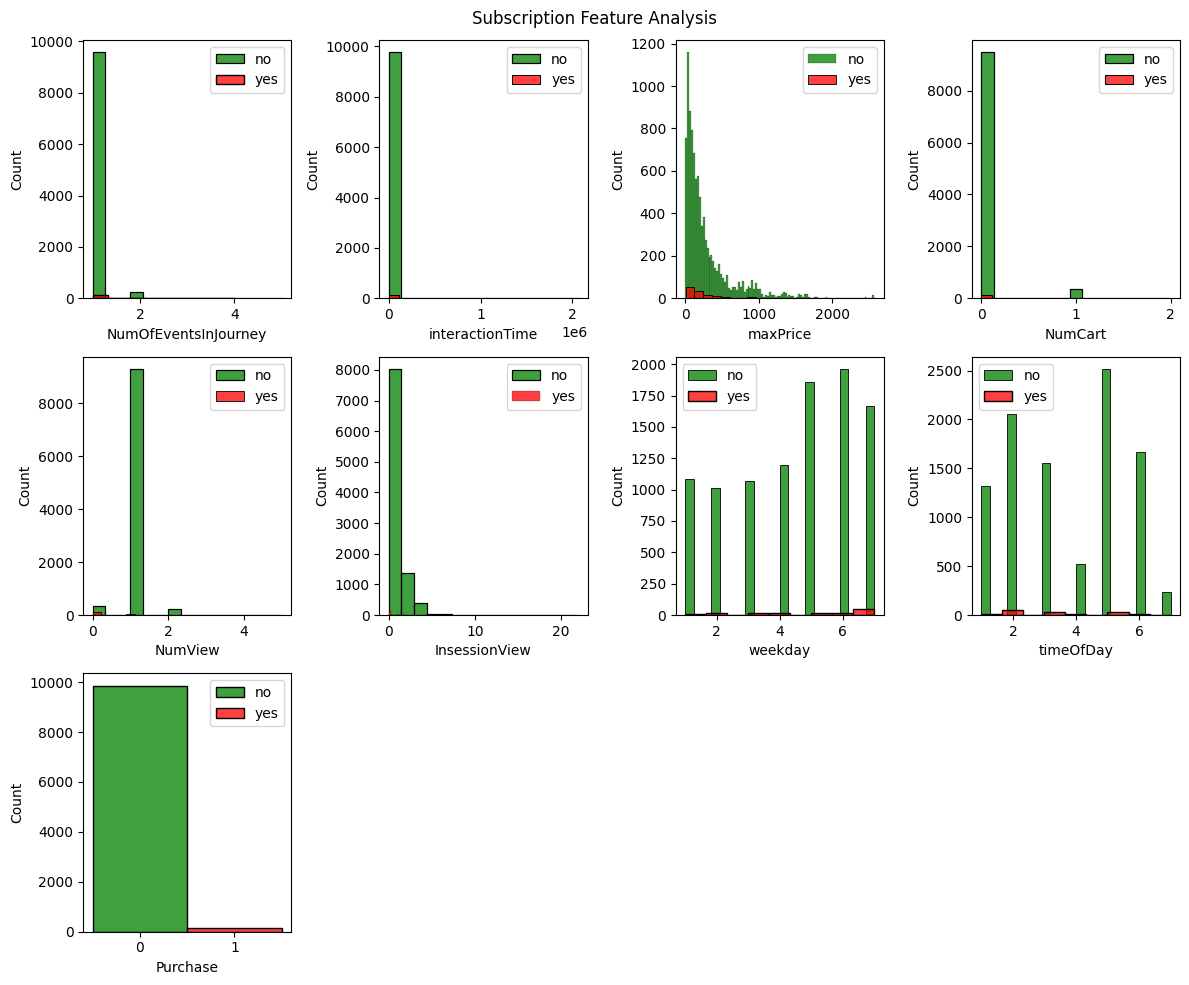

In [26]:
%matplotlib inline         

#--- Workaround:  I had to add the above magic cmd to get matplotlib to display

import matplotlib.pyplot as plt
import seaborn as sns
train_small_df_reduced = train_small_df[selected_columns]
fig = plt.figure(figsize=(12, 10))
j = 0
for i in train_df_reduced.columns:
    plt.subplot(3, 4, j + 1)
    j += 1
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 0], color='g', label='no')
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 1], color='r', label='yes')
    plt.legend(loc='best')
    
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95);

6. Make the NumPy arrays `X_train_reduced`, `X_test_reduced`, `y_train` and `y_test` from `train_df_reduced` and `test_df_reduced`. 

In [27]:
y_train = train_df_reduced['Purchase'].values
y_test = test_df_reduced['Purchase'].values         # YOUR CODE HERE

X_train_reduced = train_df_reduced.drop(columns='Purchase').values
X_test_reduced = test_df_reduced.drop(columns='Purchase').values         # YOUR CODE HERE

7. Scale the features in `X_train_reduced` and `X_test_reduced` use `MinMaxScaler`

In [28]:
from sklearn.preprocessing import MinMaxScaler


#---
scaler = MinMaxScaler().fit(X_train_reduced)                #--- fit the MinMaxScaler on the training data YOUR CODE HERE
X_train_reduced = scaler.transform(X_train_reduced)         #--- transform x_train 
X_test_reduced = scaler.transform(X_test_reduced)           #--- transform x_test

In [29]:
type(X_train_reduced)


numpy.ndarray

## Task 4: Build Logistic Regression and SVM models

We will be fitting both a Logistic Regression and SVM model to the reduced features and then looking at classification metrics such as Accuracy, Precision, Recall, and F1-score.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score as accuracy,
    recall_score as recall,
    precision_score as precision,
    f1_score
)

1. Instantiate, train, and predict using the Logistic Regression model.

    Make sure to account for the imbalanced classes with with `class_weight` parameter (what happens if we don't?).

    Remember to use the ***train*** data for training the model and the ***test*** data when making predictions.

In [31]:
%%time
lr_model = LogisticRegression(class_weight='balanced', random_state=42).fit(X_train_reduced, y_train)   # YOUR CODE HERE
lr_pred = lr_model.predict(X_test_reduced)                                             # YOUR CODE HERE

CPU times: user 6.51 s, sys: 3.28 s, total: 9.79 s
Wall time: 2.58 s


2. Calculate these classification metrics for the Logistic Regression model:

    * accuracy
    * precision
    * recall
    * f1 score
    * confusion matrix

In [32]:
print("accuracy:", accuracy(y_test, lr_pred))
print("precision:", precision(y_test, lr_pred))
print("recall:", recall(y_test, lr_pred))
print("f1 score:", f1_score(y_test, lr_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, lr_pred))

accuracy: 0.9999651603552715
precision: 0.997717267242785
recall: 0.9998366013071895
f1 score: 0.9987758100057129
confusion matrix:
[[424410     14]
 [     1   6119]]


3. Instantiate, train and predict using the SVM model. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for usage. 

    Again, remember to account for the class imbalance.

In [33]:
%%time
#--- default SVC:  C=1;  loss=squared_hinge;  
svm_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=10000)     # YOUR CODE HERE 
svm_model.fit(X_train_reduced, y_train)
svm_pred = svm_model.predict(X_test_reduced)



CPU times: user 2min 59s, sys: 0 ns, total: 2min 59s
Wall time: 2min 59s


In [34]:
print("accuracy:", accuracy(y_test, svm_pred))
print("precision:", precision(y_test, svm_pred))
print("recall:", recall(y_test, svm_pred))
print("f1 score:", f1_score(y_test, svm_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, svm_pred))



accuracy: 1.0
precision: 1.0
recall: 1.0
f1 score: 1.0
confusion matrix:
[[424424      0]
 [     0   6120]]


4. ❓ What is the time complexity of SVM? What is it for Logistic Regression? Not familiar with the term "time complexity"? Take a read on [Computational Complexity of ML Models
](https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770).

    YOUR ANSWER HERE
    
    Where n is the number of training data samples, and d is the number of dimensions of the data (features) ...
    
    A:  Time-complexity for SVM:  O(n^2)
    A:  Time-complexity for LR:   O(nd)
    

5. Calculate the classification metrics for the SVM model. 

Here you can use a helper function to display all the metrics. 

Inspect the source code to understand how to use the function. 

In [35]:
from utils import display_metrics
display_metrics(y_test, svm_pred)

Confusion Matrix: 
[[424424      0]
 [     0   6120]]
Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1 Score: 1.000


Wow, that's impressive! Why do you think SVM performs so well? If you are not familiar with Support Vector Machine, check [In-Depth: Support Vector Machines](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb) out for better understanding. 

## Task 5: Explanability with SHAP

Intepretation of a linear model such as logistic regression is staightforward, however, some tree-based models have a different reputation. In this task, we will fit a non-linear classifier: begin with gradient boosted tree, and use SHAP to help intepret the model. 

1. What are training coefficients from logistic regression? ( how about SVM? check [How does one interpret SVM feature weights?](https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights) )

    Leave your comments on interpretation of this logistic regression model.

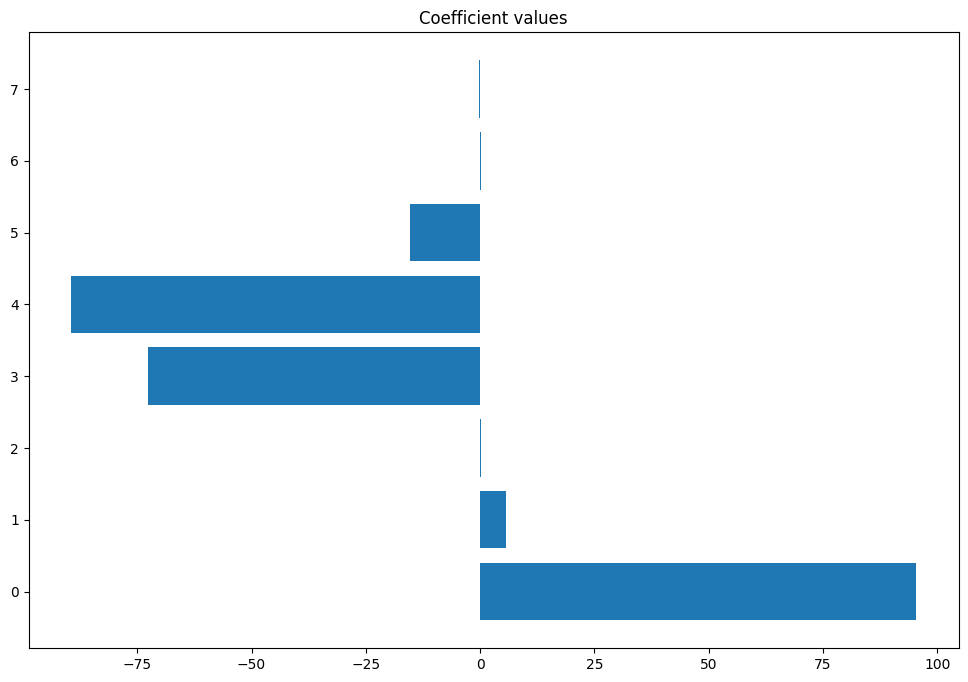

In [36]:
#--- Logistic Regression Coefficients
plt.figure(figsize=(12,8))
plt.barh(pd.DataFrame(X_train_reduced).columns, lr_model.coef_[0])
plt.title("Coefficient values")
plt.show()

In [37]:
#--- INSPECT:  the intercept of 5.13 
#--- +intercept:  probability of the outcome is > 0.5 [>50%]
lr_model.intercept_


array([5.13501153])

In [38]:
#--- INSPECT:  logistic regression coefficients
#--- feat0:  95.38 -> NumEvents greatly increases prob of Purchase
#--- feat1:  5.56 ->  interactionTime increases prob of Purchase
#--- feat3:  -72.72-> NumCart greatly decreases prob of Purchase
#--- feat4:  -89.52-> NumView signifiantly decreases prob of Purchase
#--- feat5:  -15.37-> InsessionView decreases prob of Purchase
lr_model.coef_


array([[ 95.38682777,   5.56700081,   0.14212635, -72.72528366,
        -89.52367489, -15.36766858,   0.09815998,  -0.22694872]])

#--- INSPECT:  Coefficient Values

#--- Columns/features listed from index 0 ...
['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart', 'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase']


#--- INTERPRETATION:
- an increase in NumOfEventsJourney (and to a much smaller degree, interactionTime) is more likely to lead to a Purchase
- conversely, an increase in NumCart, NumView (and to a smaller degree InsessionView) is more likely to lead to non-Purchase



In [39]:
#--- SVM Coefficients
svm_model.coef_


array([[ 2.19440778e+01,  1.51350044e-02,  4.46894401e-05,
        -1.79398795e+01, -1.79713406e+01, -1.30003326e-01,
         1.39250871e-04, -1.46060536e-04]])

2. Instantiate, train, and predict using the Gradient Boosted Trees model.

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
%%time
gbt_model = GradientBoostingClassifier(random_state=42)       # YOUR CODE HERE
gbt_model.fit(X_train_reduced, y_train)
gbt_pred = gbt_model.predict(X_test_reduced)



CPU times: user 44.2 s, sys: 25.4 ms, total: 44.2 s
Wall time: 44.2 s


3. Evaluate the model by calculating the classification metrics.

In [42]:
# YOUR CODE HERE
display_metrics(y_test, gbt_pred)



Confusion Matrix: 
[[424423      1]
 [    16   6104]]
Accuracy: 1.000
Recall: 0.997
Precision: 1.000
F1 Score: 0.999


4. SHAP (SHapley Additive exPlanations) is a game theory approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. You can use package [SHAP](https://github.com/slundberg/shap). 

    For this task, if you are not familar with the concept, read the book chapter [Interpretable Machine Learning - A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/shap.html) first. 

5. Consider experimenting on a smaller dataset. 

For example, start with a subset of 100 samples from the test data.

Once the script works properly, use all the data from `X_test_reduced`. 

Apply `shap.Explainer()` to calculate the SHAP values for the Gradient Boosting classifier you fit earlier.

In [43]:
print(X_test_reduced.shape[0])

430544


In [44]:
np.random.seed(123)
subset_size = 100    #X_test_reduced.shape[0]           # start with 100
#subset_size = X_test_reduced.shape[0]           # start with 100
idx = np.random.randint(X_test_reduced.shape[0], size=subset_size)
X_test_reduced_subset = X_test_reduced[idx, ]

assert X_test_reduced_subset.shape == (subset_size, 8)

In [45]:
import shap
explainer = shap.Explainer(gbt_model, X_test_reduced_subset)                   # YOUR CODE HERE

In [46]:
%%time
shap_values = explainer(X_test_reduced_subset)         # YOUR CODE HERE

CPU times: user 73.6 ms, sys: 190 µs, total: 73.8 ms
Wall time: 72.9 ms


6. visualize the effects over all samples using `shap.plots.beeswarm()` or `shap.summary_plot()`. 

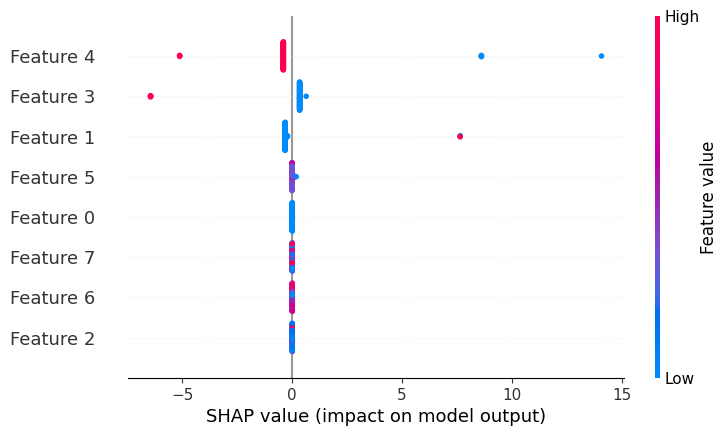

In [47]:
# YOUR CODE HERE
shap.plots.beeswarm(shap_values)

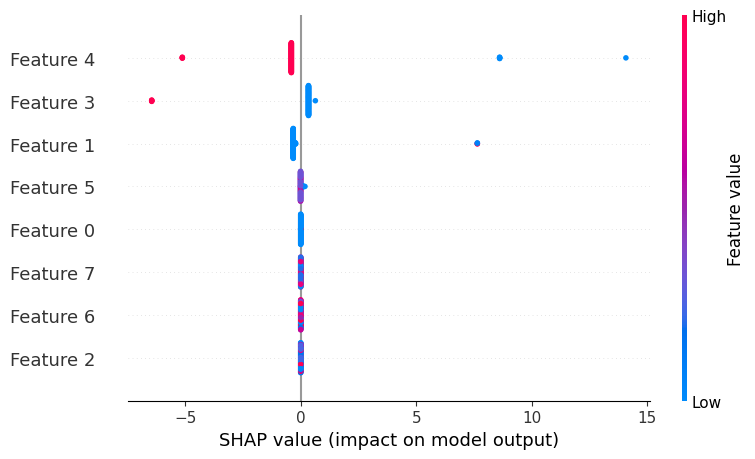

In [48]:
shap.summary_plot(shap_values, X_test_reduced_subset)

7. What are features 4, 3, and 1? Does each feature positively or negatively contribute to the likelihood of purchase?

In [ ]:
# YOUR CODE HERE
#--- Assert:  Positive outcome == Purchase
#--- Feature 4:  higher NumView yields negative outcome.  Lower NumView yields positive outcome.
#--- Feature 3:  higher NumCart yields negative outcome.  Lower NumCart yields slightly positive outcome.
#--- Feature 1:  lower InteractionTime yields some negative outcome.  High InteractionTime yields some positive outcome. 


8. Visualize the effects over all samples using `shap.plots.beeswarm()` or `shap.summary_plot()`. 

100%|===================| 428842/430544 [03:02<00:00]        

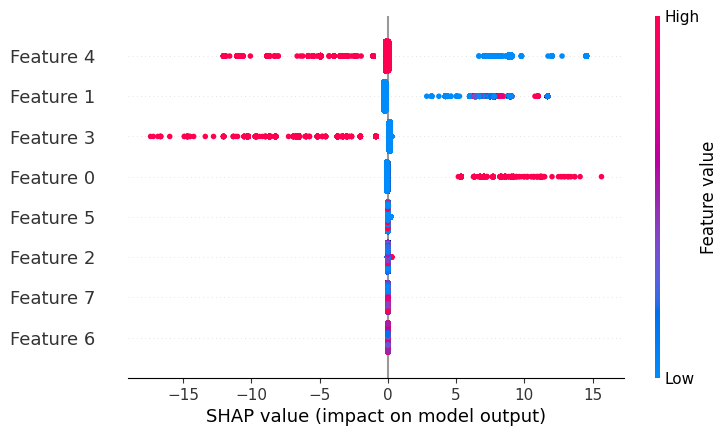

CPU times: user 3min 22s, sys: 1.49 s, total: 3min 23s
Wall time: 3min 20s


In [49]:
%%time
# YOUR CODE HERE
explainer = shap.Explainer(gbt_model, X_test_reduced)                   # YOUR CODE HERE

shap_values = explainer(X_test_reduced)   
shap.plots.beeswarm(shap_values)

9. Write your data (shap values) to a file and add them under the Model Explainability tab in the Streamlit app (see next section), following the example in Model Results tab.


#--- Research:
Q:  Options to export shap values to a file -> plt.savefig();  png, pdf
Q:  Options to add shap data under the Model Explainability tab in Streamlit

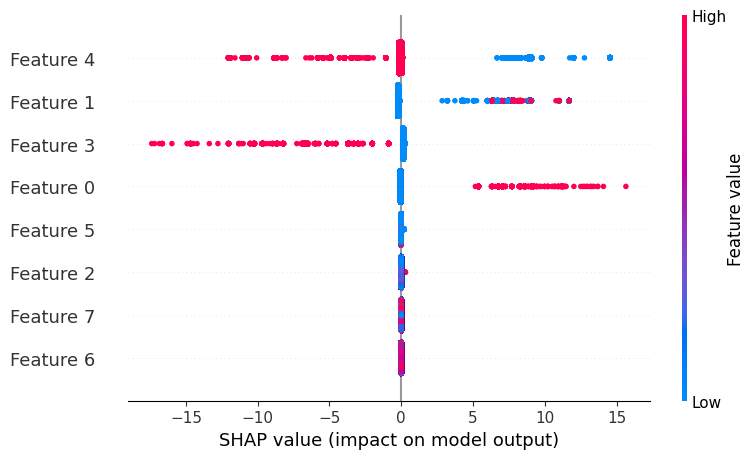

In [50]:
shap.summary_plot(shap_values, show=False)
plt.savefig("shap_summary.png",dpi=700) #png,.pdf


10. Optional. Do the same for a random forest model.


Q:  What does this mean?  Do what the same?
Assumed:  Repeat the whole exercise of 
- model fit, prediction, 
- confusion matrix, and 
- explainability but for a random forest model ...


#>>> CODE BEGINS HERE

%%time

#--- instantiate the model, fit, and predict

rfr_model = RandomForestRegressor()
rfr_model.fit(X_train_reduced, y_train)
rfr_pred = rfr_model.predict(X_test_reduced)

#--- display confusion matrix
display_metrics(y_test, gbt_pred)

#--- generate the explainer
explainer = shap.Explainer(rfr_model, X_test_reduced)     

#--- get shap values
shap_values = explainer(X_test_reduced)   
shap.summary_plot(shap_values)

#<<< CODE ENDS HERE


## Task 6: AutoML

Let's see how AutoML performs on this imbalanced dataset. Similarly, for faster iteration on our workflow, experiment it on a small smaple. 

1. Take 5,000 samples from `train_df`, 5,000 from `test_df` for experimenting.

In [51]:
train_features = train_df.sample(int(5e3), random_state=42)
train_label = train_features.pop('Purchase')
test_features = test_df.sample(int(5e3), random_state=42)
test_label = test_features.pop('Purchase')

2. Instantiate and train a TPOT auto-ML classifier.

    The parameters in the code below are set to low values for faster iterations. 
    Read about each parameters [here](http://epistasislab.github.io/tpot/api/#classification) and experiment with different values when time permits.
    
    Set a proper [`scoring` function](http://epistasislab.github.io/tpot/using/#scoring-functions). 

#--- PREREQS:
- tpot library not listed in reqs.txt;  imported manually


In [52]:
%%time
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=10, 
                      population_size=16,
                      scoring='accuracy',        # http://epistasislab.github.io/tpot/api/
                      verbosity=2,
                      random_state=42)
tpot.fit(train_features, train_label)
print(f"Tpop score on test data: {tpot.score(test_features, test_label):.2f}")
tpot.export('tpot_electronics_pipeline.py')

Optimization Progress:   0%|          | 0/176 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9994

Generation 2 - Current best internal CV score: 0.9994

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Generation 6 - Current best internal CV score: 1.0

Generation 7 - Current best internal CV score: 1.0

Generation 8 - Current best internal CV score: 1.0

Generation 9 - Current best internal CV score: 1.0

Generation 10 - Current best internal CV score: 1.0

Best pipeline: GradientBoostingClassifier(FastICA(MinMaxScaler(input_matrix), tol=0.35000000000000003), learning_rate=0.01, max_depth=4, max_features=0.9000000000000001, min_samples_leaf=20, min_samples_split=6, n_estimators=100, subsample=0.4)
Tpop score on test data: 1.00
CPU times: user 9min 9s, sys: 3min 57s, total: 13min 6s
Wall time: 5min 43s


sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.


3. Examine the model pipeline that TPOT classifier offers in the python file `tpot_electronics_pipeline.py` in the `nb` directory. 
If you see any model, function, or class that are not familiar, look them up!

    Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate.

In [53]:
!cat tpot_electronics_pipeline.py   #--- adjusted output

import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from tpot.export_utils import set_param_recursive

kstrTrainFile = "../dat/train_df.csv"
kstrTargetCol = 'Purchase'

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
#tpot_data = pd.read_csv(kstrTrainFile, sep=',', dtype=np.float64)
#tpot_data = pd.read_csv(kstrTrainFile, compression='gzip')
tpot_data = pd.read_csv(kstrTrainFile, sep=',', dtype=np.float64)

features = tpot_data.drop(kstrTargetCol, axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data[kstrTargetCol], random_state=42)

# Average CV score on the training set was: 1.0
exported_pipeline = make_pipeline(
    MinMaxScaler(),
    FastICA(tol=0.3500

4. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_electronics_pipeline.py` to build a model on our training set and make predictions on the test set. 

    Choose approriate metrics to evaluate the prediction from TPOT. 
    
    Optional. Add this to Streamlit `models` in the next section.

In [55]:
#--- updated to change path to dataframe

import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from tpot.export_utils import set_param_recursive

kstrTargetCol = 'Purchase'

tpot_data = pd.concat([train_df, test_df]) 
features = tpot_data.drop(kstrTargetCol, axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data[kstrTargetCol], \
            random_state=42)



In [56]:
#--- INSPECT:  build model, predict on training set based on generated tpot .py

#--- Average CV score on the training set was: 1.0
exported_pipeline = make_pipeline(
    MinMaxScaler(),
    FastICA(tol=0.35000000000000003),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=4, max_features=0.9000000000000001, min_samples_leaf=20, min_samples_split=6, n_estimators=100, subsample=0.4)
)


# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


From version 1.3 whiten='unit-variance' will be used by default.


In [57]:

#--- INSPECT:  model performance 
display_metrics(testing_target, results)


Confusion Matrix: 
[[265263      0]
 [     0   3827]]
Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1 Score: 1.000


## Advanced Visualizations with Streamlit and Plotly!
Let's visualize our results in a way that makes it easy to compare our models!  
[Streamlit](https://streamlit.io/) is a Python package that makes it easy to create bespoke, dynamic and interactive web apps for visualizations.  
Lightweight web apps like this are a great way to present results to stakeholders! 

First we need to build our results dataset to render in Streamlit.

In [58]:
from collections import defaultdict

results_data = defaultdict(list)

models = ["Logistic Regression", "SVM", "Gradient Boosting Classifier"]

for model, pred in zip(models, [lr_pred, svm_pred, gbt_pred]):
    confusion = confusion_matrix(y_test, pred)
    accuracy_ = accuracy(y_test, pred)
    recall_ = recall(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    results_data['model'].append(model)
    results_data['tn'].append(confusion[0][0])
    results_data['fp'].append(confusion[0][1])
    results_data['fn'].append(confusion[1][0])
    results_data['tp'].append(confusion[1][1])
    results_data['accuracy'].append(accuracy_)
    results_data['recall'].append(recall_)
    results_data['f1_score'].append(f1)
results_df = pd.DataFrame(results_data)
results_df


,model,tn,fp,fn,tp,accuracy,recall,f1_score
0,Logistic Regression,424410,14,1,6119,0.999965,0.999837,0.998776
1,SVM,424424,0,0,6120,1.000000,1.000000,1.000000
2,Gradient Boosting Classifier,424423,1,16,6104,0.999961,0.997386,0.998609


In [59]:


# Write our results_df to CSV
results_df.to_csv("../dat/model_results.csv")


2. Then, we need to built Stremlit app. 
For today's assignment, we wrote the code for you.
However, understand the code in `electronics_purchase_predictions_stremlit.py` because you might need to write a Streamlit web app on your own for the future assignments. 

3. Once you inspected the code, you will need to start streamlit from CLI. 
Try looking up how to do this yourself.

HINT: this is a python file - maybe if you run it as a python file from the CLI, it will give you further instructions. 

Note - once you run the stremlit, the prompt will ask you to provide an email. 
You can leave the email blank. 

And you are done! 

#--- prereqs:
- conda activate env
- streamlit run <streamlitApp.py>
- ctl-click on local url

## References

- This work is motivated by this [publication](https://arxiv.org/pdf/2010.02503.pdf) 
- [Comprehensive Guide on Feature Selection](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook)
- [Common pitfalls and recommended practices](https://scikit-learn.org/stable/common_pitfalls.html)
- [Interactive Shapley Value Demonstration in Python](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Interactive_Shapley_Values.ipynb)
- [Subsurface Data Analytics](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb)